# Lab 4: Natural Language Inference with Attention Mechanism

In this lab session we will implement attention model for NLI based on  [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) initial model (non word-by-word). Although there are more complicated attention models (see for example the word-by-word attention model), it is interesting enough to understand how attentions work and how it is possible to implement with PyTorch.

For this we'll focus on a different NLP task: __Natural Language Inference__ (NLI). NLI consists in determining whether a natural language _hypothesis_ can justifiably be inferred from a natural language _premise_. Thus given a pair of  premise  and  hypothesis texts, the task is to classify them into three categories: _entailment_, _contradiction_, and _neutral_. The table below shows a few examples of premise/hypothesis along with the annotated labels (examples taken from [here](https://nlp.stanford.edu/pubs/snli_paper.pdf)).

The dataset we will use in this lab can be downloaded from [here](https://nlp.stanford.edu/projects/snli/) and it is a corpus comprised by The Stanford Natural Language Processing Group. Actually we are using a subset of the whole dataset. We'll give more details about the dataset in the next section.

| Premise                                                               | Category      | Hypothesis                                                         |
|:--------------------------------------------------------------------|:---------------|:--------------------------------------------------------------------|
| A man inspects the uniform of a figure in some East Asian country. | contradiction | The man is sleeping                                                |
| An older and younger man smiling.                                  | neutral       | Two men are smiling and laughing at the cats playing on the floor. |
| A black race car starts up in front of a crowd of people.          | contradiction | A man is driving down a lonely road.                               |
| A soccer game with multiple males playing.                         | entailment    | Some men are playing a sport.                                     |
| A smiling costumed woman is holding an umbrella.                   | neutral       | A happy woman in a fairy costume holds an umbrella.                |


## The PyTorch Module API
As you might note in order to predict the correct label we might need to be able to accept multiple independent inputs. In PyTorch, models are typically built using `nn.Module` which allows for flexible architectures, unlike a strictly sequential stack of layers. This permits designing arbitrary graph structures.
In the PyTorch Module API, we define the forward pass by manipulating tensors. That is, we use `nn.Module` subclasses and their `forward` methods to define how layers interact. You have further information [here](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), and you can find an example of a MLP model below.



## Attention Model
We will make some simplification to the model presented in [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) model. In our case, the conditional encoding of the sentences is obtained usin two different ```GRU``` layers. The premise is read by one ```GRU``` and the hypothesis sentence is read by the other GRU that learns different parameters. Two ```GRU``` layers are connected in a way that the second ```GRU``` is initialized with the last cell state of the premise GRU like shown in the example (the figure is taken from [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) paper).  

![image](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/main_arc.jpeg)

The paper proposes two attention models, we'll focus on the non word-by-word attention (Figure B), which is described in Section 2.3 of the paper. The model learns to capture important pieces of information of the premise based on the last output of the hypotesis (which contains the semantics of the hypothesis sentences). Please go through the paper to know about the mathematical details.


----
The main __objectives__ of this lab are the following:
 - Understant attention mechanism.
 - Learn to implement it in PyTorch.
 - Use the `nn.Module` API of PyTorch.
 - Implement architecture that accept multiple inputs.

In [7]:
# install libraries
!pip install datasets==2.17.1
# import load_dataset from dataset
from datasets import load_dataset
# set seed for replicability of results
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
import time
from torch.utils.data import DataLoader, TensorDataset
import json
import torch.nn.functional as F

np.random.seed(2)

In [8]:
# device - PyTorch requires explicit device management
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Note: In PyTorch, you need to explicitly move tensors and models to the device using .to(device)

Using device: cuda


## Functional API Example
As explained above, when using the `nn.Module` API we define layers as operations that take tensors and return tensors. The way we combine these operations defines the model that can be seen as a graph-like data structure. Once we define all tensor operations, we implement the `forward` method to specify the input and output flow.

In this simple example we will create an MLP model that combines two `nn.Linear` layers (we are not going to train as we are not loading the data, but feel free to play with it).

In [9]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid()
        )
        self.criterion = nn.BCELoss() # just to make the criterion switch easier

    def forward(self, input, target=None):
        probs = self.layers(input)
        if target is not None: # compute loss if desired targets are given
          loss = self.criterion(probs, target)
        else:
          loss = None
        return probs, loss

In [10]:
# model
model = Classifier(
    input_dim=64,
    hidden_dim=32,
    num_classes=1
    ).to(device)

# Print model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Classifier(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (criterion): BCELoss()
)
Total parameters: 2113
Trainable parameters: 2113


## 1. Load data
In a similar way as in previous labs, we'll first load the data and inspect it. The data will be loaded from HuggingFace with the next function```load_dataset("stanfordnlp/snli")``` (the data is the same the one that you can downloaded from [here](https://nlp.stanford.edu/projects/snli/) , but we get rid off stuff we do not need this lab).

The dataset consists of the following three divisions:
-  ```snli_1.0_train.tsv.bz2```
- ```snli_1.0_dev.tsv.bz2```
-  ```snli_1.0_test.tsv.bz2```

-----

It is good idea before we upload the data to make sure that GPUs are visible for the notebook.

In [11]:
## check that your notebook sees a GPU, otherwise it would take for ever.
if device.type != 'cuda':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

Found GPU at: cuda


-----
Now we are ready to mount our Drive files:

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
data = load_dataset("stanfordnlp/snli")
data = data.filter(lambda example: example["label"] != -1)
training_set = pd.DataFrame(data['train'])
dev_set = pd.DataFrame(data['validation'])
test_set = pd.DataFrame(data['test'])

print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

Training size: 549367
Dev size: 9842
Test size: 9824


In [14]:
training_set.head()

,premise,hypothesis,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",2
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0
3,Children smiling and waving at camera,They are smiling at their parents,1
4,Children smiling and waving at camera,There are children present,0


In [15]:
import re
from collections import Counter
import torch

class TorchTokenizer:
    def __init__(self, num_words=10000, oov_token="<unk>"):
        self.num_words = num_words
        self.oov_token = oov_token
        self.word_index = {oov_token: 1}  # reserve 0 for padding
        self.index_word = {1: oov_token}
        self.word_counts = Counter()

    def fit_on_texts(self, texts):
        for text in texts:
            # simple tokenizer: alphanumeric word boundaries
            for w in re.findall(r"\b\w+\b", str(text).lower()):
                self.word_counts[w] += 1
        # most common words (excluding padding)
        most_common = self.word_counts.most_common(self.num_words - 1)
        # start from 2 because 0=pas, 1=oov
        for idx, (word, _) in enumerate(most_common, start=2):
            self.word_index[word] = idx
            self.index_word[idx] = word

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            seq = []
            for w in re.findall(r"\b\w+\b", str(text).lower()):
                idx = self.word_index.get(w, self.word_index[self.oov_token])
                # keep indices in range [0, num_words-1]
                if idx < self.num_words:
                    seq.append(idx)
                else:
                    seq.append(self.word_index[self.oov_token])
            sequences.append(seq)
        return sequences


def pad_sequences(sequences, maxlen):
    batch_size = len(sequences)
    x = torch.zeros((batch_size, maxlen), dtype=torch.long)
    for i, seq in enumerate(sequences):
        if len(seq) == 0:
            continue
        if len(seq) <= maxlen:
            x[i, :len(seq)] = torch.tensor(seq, dtype=torch.long)
        else:
            x[i, :] = torch.tensor(seq[:maxlen], dtype=torch.long)
    return x

def to_categorical(y, num_classes=None):
    if num_classes is None:
        num_classes = len(torch.unique(y))

    # Create one-hot encoding
    y_one_hot = torch.zeros(len(y), num_classes, dtype=torch.float32)
    y_one_hot.scatter_(1, y.unsqueeze(1), 1)
    return y_one_hot

def get_data_loaders(batch_size, train_dataset, dev_dataset, test_dataset):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader, test_loader

In [16]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()

    total_loss = 0
    correct = 0
    total = 0

    for premise, hypothesis, targets in data_loader:
        premise = premise.to(device)
        hypothesis = hypothesis.to(device)
        targets = targets.to(device)

        # forward pass
        logits, loss = model(premise, hypothesis, targets)
        total_loss += loss.item() * premise.size(0)

        # For multi-class classification, get predictions
        _, predicted = torch.max(logits.data, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    loss = total_loss / total
    acc = correct / total
    model.train()

    return loss, acc

def train_loop(model, optimizer, epochs, patience=None, monitor="dev_acc"):

    # train mode for model
    model.train()

    history = {"loss": [], "dev_loss": [], "acc": [], "dev_acc": []}
    t0 = time.time()
    t_prev = t0

    # early stopping state
    best_metric = None
    patience_left = patience

    # perform the loop
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for premise, hypothesis, targets in train_loader:
            premise = premise.to(device)
            hypothesis = hypothesis.to(device)
            targets = targets.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward pass
            logits, loss = model(premise, hypothesis, targets)

            # backward pass
            loss.backward()

            # optimizer step
            optimizer.step()

            # compute metrics
            total_loss += loss.item() * premise.size(0)
            total += targets.size(0)
            with torch.no_grad():
                _, predicted = torch.max(logits.data, 1)
                correct += (predicted == targets).sum().item()

        loss = total_loss / total
        acc = correct / total

        # Evaluation
        dev_loss, dev_acc = evaluate(model, dev_loader)

        # Store info
        history["loss"].append(loss)
        history["dev_loss"].append(dev_loss)
        history["acc"].append(acc)
        history["dev_acc"].append(dev_acc)

        # Logging
        t = time.time()
        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train loss: {loss:.4f} - "
            f"Train acc: {acc:.4f} - "
            f"Dev loss: {dev_loss:.4f} - "
            f"Dev acc: {dev_acc:.4f} - "
            f"Time: {(t - t_prev)*1000:.2f}ms"
        )

        # Early stopping update
        if patience:
            current = history[monitor][-1]
            if best_metric is None:
                best_metric = current
            improved = (current >= best_metric) if monitor == "dev_acc" else (current <= best_metric)
            if improved:
                best_metric = current
                patience_left = patience
            else:
                patience_left -= 1
            if patience_left <= 0:
                print("Early stopping triggered")
                break

        # Updates
        t_prev = t

    print(f"Total training time: {t-t0}")
    return history

# Plot curves and evaluate on test set
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history['loss'])
    plt.plot(history['dev_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show()

    plt.plot(history['acc'])
    plt.plot(history['dev_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show()

In [17]:
# Configuration
max_words = 10000
max_seq = 40
num_classes = 3  # entailment, neutral, contradiction

# Prepare vocabulary
train_texts = list(training_set.premise) + list(training_set.hypothesis)

# Create tokenizer that takes the most common words
tokenizer = TorchTokenizer(num_words=max_words)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts)  # Create word index using only training part
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10000 unique tokens.


In [18]:
# Get data as lists of integers
train_premises = tokenizer.texts_to_sequences(training_set.premise)
train_hypotheses = tokenizer.texts_to_sequences(training_set.hypothesis)

dev_premises = tokenizer.texts_to_sequences(dev_set.premise)
dev_hypotheses = tokenizer.texts_to_sequences(dev_set.hypothesis)

test_premises = tokenizer.texts_to_sequences(test_set.premise)
test_hypotheses = tokenizer.texts_to_sequences(test_set.hypothesis)

# Convert to tensors with padding using the pad_sequences function
x_train_premises = pad_sequences(train_premises, max_seq)
x_train_hypotheses = pad_sequences(train_hypotheses, max_seq)

x_dev_premises = pad_sequences(dev_premises, max_seq)
x_dev_hypotheses = pad_sequences(dev_hypotheses, max_seq)

x_test_premises = pad_sequences(test_premises, max_seq)
x_test_hypotheses = pad_sequences(test_hypotheses, max_seq)

# Convert labels to PyTorch tensors
# For NLI task: 0=entailment, 1=neutral, 2=contradiction
y_train_labels = torch.tensor(training_set.label.values, dtype=torch.long)
y_dev_labels = torch.tensor(dev_set.label.values, dtype=torch.long)
y_test_labels = torch.tensor(test_set.label.values, dtype=torch.long)

# Create one-hot encoded labels
y_train = to_categorical(y_train_labels, num_classes)
y_dev = to_categorical(y_dev_labels, num_classes)
y_test = to_categorical(y_test_labels, num_classes)

# Create datasets using PyTorch's TensorDataset
train_dataset = TensorDataset(x_train_premises, x_train_hypotheses, y_train_labels)
dev_dataset = TensorDataset(x_dev_premises, x_dev_hypotheses, y_dev_labels)
test_dataset = TensorDataset(x_test_premises, x_test_hypotheses, y_test_labels)

print(f"Training premises shape: {x_train_premises.shape}")
print(f"Training hypotheses shape: {x_train_hypotheses.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Training labels (integer) shape: {y_train_labels.shape}")
print(f"Number of classes: {num_classes}")
print(f"Class distribution (integer): {torch.bincount(y_train_labels)}")
print(f"Vocabulary size: {len(word_index)}")
print(f"Max sequence length: {max_seq}")

# Show example of one-hot encoding
print(f"\nExample one-hot encoding:")
print(f"Integer label 0 -> {y_train[0]}")
print(f"Integer label 1 -> {y_train[1]}")
print(f"Integer label 2 -> {y_train[2]}")

Training premises shape: torch.Size([549367, 40])
Training hypotheses shape: torch.Size([549367, 40])
Training labels shape: torch.Size([549367, 3])
Training labels (integer) shape: torch.Size([549367])
Number of classes: 3
Class distribution (integer): tensor([183416, 182764, 183187])
Vocabulary size: 10000
Max sequence length: 40

Example one-hot encoding:
Integer label 0 -> tensor([0., 1., 0.])
Integer label 1 -> tensor([0., 0., 1.])
Integer label 2 -> tensor([1., 0., 0.])


## 2. Conditional Model with no Attention
Before we create a conditional model with attention, it is a good idea to build a baseline model that does not learn any kind of attention.

The baseline model concatenates two GRU layers in a way that the second one is initialized with the last hidden state of the first one. This can be achieved by passing the final hidden state of the first GRU to the second GRU.

In [19]:
class NLIModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_classes, pad_idx=0):
        super().__init__()
        self.pad_idx = pad_idx
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        # Shared embedding layer for both premise and hypothesis
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=self.pad_idx)

        # GRU layers
        self.premise_gru = nn.GRU(
            input_size=embedding_size,
            hidden_size=hidden_size,
            batch_first=True
        )

        self.hypothesis_gru = nn.GRU(
            input_size=embedding_size,
            hidden_size=hidden_size,
            batch_first=True
        )

        # Classifier
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, premise_input, hypothesis_input, targets=None):
        # Embedding lookup
        embedded_premise = self.embedding(premise_input)
        embedded_hypothesis = self.embedding(hypothesis_input)

        # Process premise through GRU
        premise_output, premise_hidden = self.premise_gru(embedded_premise)

        # Process hypothesis through GRU, initialized with premise hidden state
        hypothesis_output, _ = self.hypothesis_gru(embedded_hypothesis, premise_hidden)

        # Use the last output from hypothesis GRU for classification
        # hypothesis_output shape: [batch_size, seq_len, hidden_size]
        # We want the last timestep: [batch_size, hidden_size]
        last_hidden = hypothesis_output[:, -1, :]

        # Classification
        logits = self.classifier(last_hidden)

        if targets is not None:
            loss = self.criterion(logits, targets)
        else:
            loss = None

        return logits, loss

    def to_json(self):
        config = {
            "class_name": "NLIModel",
            "config": {
                "vocab_size": self.vocab_size,
                "embedding_size": self.embedding_size,
                "hidden_size": self.hidden_size,
                "num_classes": self.num_classes,
                "pad_idx": self.pad_idx
            },
            "architecture": {
                "embedding": {
                    "type": "Embedding",
                    "vocab_size": self.vocab_size,
                    "embedding_dim": self.embedding_size,
                    "padding_idx": self.pad_idx
                },
                "premise_gru": {
                    "type": "GRU",
                    "input_size": self.embedding_size,
                    "hidden_size": self.hidden_size,
                    "batch_first": True
                },
                "hypothesis_gru": {
                    "type": "GRU",
                    "input_size": self.embedding_size,
                    "hidden_size": self.hidden_size,
                    "batch_first": True
                },
                "classifier": {
                    "type": "Linear",
                    "in_features": self.hidden_size,
                    "out_features": self.num_classes
                }
            }
        }
        return json.dumps(config, indent=2)

    @classmethod
    def from_json(cls, json_str):
        config = json.loads(json_str)
        model_config = config["config"]

        # Create model instance
        model = cls(**model_config)
        return model

    def save_weights(self, filepath):
        torch.save(self.state_dict(), filepath)

    def load_weights(self, filepath):
        self.load_state_dict(torch.load(filepath, map_location='cpu'))

In [20]:
# Hyperparameters
learning_rate = 0.0100
num_classes = 3
embedding_size = 50
hidden_size = 128
batch_size = 2048
epochs = 6

# Data loaders
train_loader, dev_loader, test_loader = get_data_loaders(
    batch_size,
    train_dataset,
    dev_dataset,
    test_dataset
    )

# Model
model = NLIModel(
    vocab_size=len(word_index),
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    num_classes=num_classes
)
model = model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/6 - Train loss: 1.0210 - Train acc: 0.4387 - Dev loss: 0.8272 - Dev acc: 0.6310 - Time: 18006.97ms
Epoch 2/6 - Train loss: 0.7900 - Train acc: 0.6524 - Dev loss: 0.7589 - Dev acc: 0.6697 - Time: 16504.05ms
Epoch 3/6 - Train loss: 0.7300 - Train acc: 0.6842 - Dev loss: 0.7245 - Dev acc: 0.6905 - Time: 17378.90ms
Epoch 4/6 - Train loss: 0.6903 - Train acc: 0.7042 - Dev loss: 0.7047 - Dev acc: 0.7014 - Time: 16027.30ms
Epoch 5/6 - Train loss: 0.6622 - Train acc: 0.7186 - Dev loss: 0.6997 - Dev acc: 0.7053 - Time: 16494.28ms
Epoch 6/6 - Train loss: 0.6433 - Train acc: 0.7273 - Dev loss: 0.6876 - Dev acc: 0.7075 - Time: 16071.49ms
Total training time: 100.48300528526306


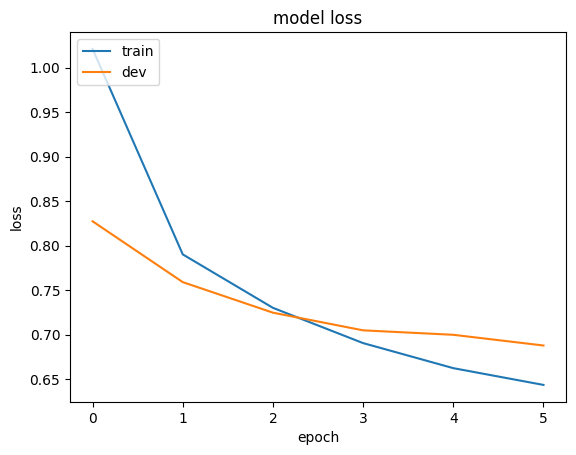

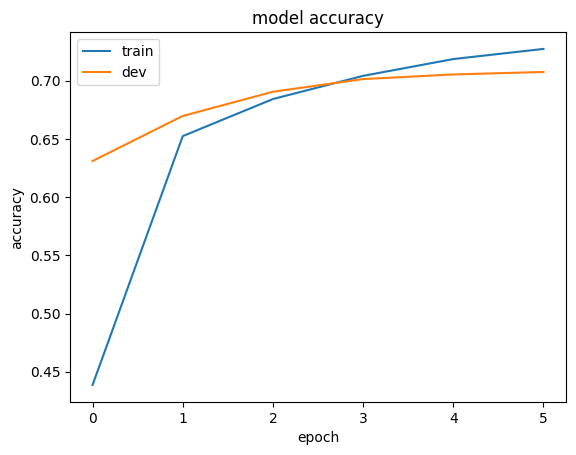

Loss:  0.6837577944081459
Accuracy:  0.7127442996742671


In [21]:
plot_history(history)

test_loss, test_acc = evaluate(model, test_loader)
print('Loss: ', test_loss)
print('Accuracy: ', test_acc)

As training takes a while, it may be a good idea to save the model for the future. (Ignore the warning message that trhows ```save_weights```  methods.)

In [22]:
# serialize model to JSON

model_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/models/'
model_json = model.to_json()
with open(model_home + 'snli-model-no_attention.json', 'w') as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(model_home + 'snli-model-no_attention.weights.h5')

!ls drive/My\ Drive/Colab\ Notebooks/dl4nlp_summer_labs/models

snli-model-no_attention.json	    snli-model-with_attention.json
snli-model-no_attention.weights.h5  snli-model-with_attention.weights.h5


In [23]:
# load json and create model
model_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/models/'
json_file = open(model_home + 'snli-model-no_attention.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

# create model instance from JSON configuration
loaded_model = NLIModel.from_json(loaded_model_json).to(device)

# load weights into the model
loaded_model.load_weights(model_home + 'snli-model-no_attention.weights.h5')

print('Loaded model from disk')

Loaded model from disk


In [24]:
test_loss, test_acc = evaluate(loaded_model, test_loader)
print('Loss: ', test_loss)
print('Accuracy: ', test_acc)

Loss:  0.6837577864479164
Accuracy:  0.7127442996742671


## 3. Conditional Model with Attention

The intuition behind the next attention mechanism is that once we read the whole hypothesis sentence and store its semantics in the last state ($\mathbf{h}_{N}$), the model looks back in the premise text to find some useful piece of information that updates the current semantics in state $\mathbf{h}_{N}$.

![image](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/snli_with_attention.png)

To learn attentions the paper proposes the following non-linear combinations:

 __Intermediate attention representation__:

> $\mathbf{M} = \tanh(\mathbf{W}^{y}\mathbf{Y} + \mathbf{W}^{h}\mathbf{h}_{N}\otimes \mathbf{e}_{L})$

> in which $\mathbf{W}^y, \mathbf{W}^ĥ \in \mathbb{R}^{k\times k}$ are trained projections matrices and $\mathbf{M} \in \mathbb{R}^{k \times L}$.   $\mathbf{e}_L \in \mathbb{R^L}$ is a vector of 1s, which its functions is to repeat $L$ times the vector obtained from  $\mathbf{W}^{h}\mathbf{h}_{N}$. $L$ is the length of the sequence, and $k$ the number of hidden units of the GRU layers.


 __Attention weights__:

> $\alpha = \text{softmax}(\mathbf{w}^T\mathbf{M}$)

> where $\mathbf{w} \in \mathbb{R}^k$ is a trained vector that parametrizes the attention given to each word in the premise, and produce a vector $\alpha \in \mathbb{R}^L$ of attention weights.

 __Attention results__:

> $\mathbf{r} = \mathbf{Y}\alpha^T$

> where $\mathbf{r} \in \mathbb{R}^k$ is the weighted representation of the premise text.



The final __sentence-pair representation__ is obtained from a non-linear combination of the attention weighted
representation $\mathbf{r}$ of the premise and the last output vector $\mathbf{h}_N$ using

> $\mathbf{h}^{*} = \tanh(\mathbf{W}^{p}\mathbf{r} + \mathbf{W}^{x}\mathbf{h}_N)$

> where  $\mathbf{h}* \in \mathbb{R}^k$ , and $\mathbf{W}^p$, $\mathbf{W}^x$ are trained projection matrices.

-----

### Exercise 1

This might look quite complicated at the beginning, so take your time to understand the tensor operations and try to think how you would implement this using PyTorch layers.

- For example, how would you implement $\mathbf{W}^{y}\mathbf{Y}$ operation using PyTorch layers?

 `nn.Linear` layers are appropriate to implement $\mathbf{W}^{y}\mathbf{Y}$. Note that in PyTorch, `nn.Linear` layers apply a linear transformation to the input: `output = input @ transpose(weight) + bias`. When `batch_first=True` for recurrent layers, the sequence length dimension is typically in the middle, so a linear layer applied to the last dimension (hidden_size) correctly performs the transformation for each timestep.


### Exercise 2

- Identify the implementation of each equation used for the attention.

```python
# 1. Intermediate attention representation
W_y = nn.Linear(hidden_size, hidden_size, bias=False)
h_premise = W_y(premise_outputs) # [batch_size, seq_len, hidden_size]

W_h = nn.Linear(hidden_size, hidden_size, bias=False)
h_hypothesis_part = W_h(hypothesis_output[:, -1, :]) # [batch_size, hidden_size]

# Repeat hypothesis part to match sequence length
h_hypothesis = h_hypothesis_part.unsqueeze(1).repeat(1, max_seq, 1) # [batch_size, seq_len, hidden_size]

added = h_premise + h_hypothesis
M = torch.tanh(added) # [batch_size, seq_len, hidden_size]

# 2. Attention weights
alpha_projection = nn.Linear(hidden_size, 1, bias=False)
alpha_scores = alpha_projection(M).squeeze(-1) # [batch_size, seq_len]
alpha = F.softmax(alpha_scores, dim=1) # [batch_size, seq_len]

# 3. Attention result
r = torch.bmm(alpha.unsqueeze(1), premise_outputs).squeeze(1) # [batch_size, hidden_size]

# 4. Sentence pair representation
W_r = nn.Linear(hidden_size, hidden_size, bias=False)
W_x = nn.Linear(hidden_size, hidden_size, bias=False)
W_r_result = W_r(r)
W_x_result = W_x(hypothesis_output[:, -1, :])
merged = W_r_result + W_x_result
h_star = torch.tanh(merged)
```

---------------------------------------

In [25]:
class NLIWithAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_classes, max_seq, pad_idx=0):
        super().__init__()
        self.pad_idx = pad_idx
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.max_seq = max_seq

        # Shared embedding layer for both premise and hypothesis
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=self.pad_idx)

        # GRU layers
        self.premise_gru = nn.GRU(
            input_size=embedding_size,
            hidden_size=hidden_size,
            batch_first=True
        )

        self.hypothesis_gru = nn.GRU(
            input_size=embedding_size,
            hidden_size=hidden_size,
            batch_first=True
        )

        # Attention mechanism layers
        # 1. Intermediate attention representation
        self.W_y = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_h = nn.Linear(hidden_size, hidden_size, bias=False)

        # 2. Attention weights
        self.alpha_projection = nn.Linear(hidden_size, 1, bias=False)

        # 3. Sentence pair representation
        self.W_r = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_x = nn.Linear(hidden_size, hidden_size, bias=False)

        # Classifier
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, premise_input, hypothesis_input, targets=None):
        # Embedding lookup
        embedded_premise = self.embedding(premise_input)
        embedded_hypothesis = self.embedding(hypothesis_input)

        # Process premise through GRU
        premise_outputs, premise_hidden = self.premise_gru(embedded_premise)

        # Process hypothesis through GRU, initialized with premise hidden state
        hypothesis_output, _ = self.hypothesis_gru(embedded_hypothesis, premise_hidden)

        # Use the last output from hypothesis GRU for classification
        # hypothesis_output shape: [batch_size, seq_len, hidden_size]
        # We want the last timestep: [batch_size, hidden_size]
        hypothesis_final = hypothesis_output[:, -1, :]

        ##                   ##
        # Calculate attention #
        ##                   ##

        # 1. Intermediate attention representation
        # W_y * premise_outputs
        h_premise = self.W_y(premise_outputs)  # [batch_size, seq_len, hidden_size]

        # W_h * hypothesis_final
        h_hypothesis_part = self.W_h(hypothesis_final)  # [batch_size, hidden_size]

        # Repeat hypothesis part to match sequence length
        h_hypothesis = h_hypothesis_part.unsqueeze(1).repeat(1, self.max_seq, 1)  # [batch_size, seq_len, hidden_size]

        # Add premise and hypothesis representations
        added = h_premise + h_hypothesis  # [batch_size, seq_len, hidden_size]
        M = torch.tanh(added)  # [batch_size, seq_len, hidden_size]

        # 2. Attention weights
        # Apply linear projection to get attention scores
        alpha_scores = self.alpha_projection(M)  # [batch_size, seq_len, 1]
        alpha_scores = alpha_scores.squeeze(-1)  # [batch_size, seq_len]

        # Apply softmax to get attention weights
        alpha = F.softmax(alpha_scores, dim=1)  # [batch_size, seq_len]

        # 3. Attention result
        # Weighted sum of premise outputs using attention weights
        # alpha: [batch_size, seq_len], premise_outputs: [batch_size, seq_len, hidden_size]
        r = torch.bmm(alpha.unsqueeze(1), premise_outputs).squeeze(1)  # [batch_size, hidden_size]

        # 4. Sentence pair representation
        W_r_result = self.W_r(r)  # [batch_size, hidden_size]
        W_x_result = self.W_x(hypothesis_final)  # [batch_size, hidden_size]
        merged = W_r_result + W_x_result  # [batch_size, hidden_size]
        h_star = torch.tanh(merged)  # [batch_size, hidden_size]

        ##                  ##
        # End of calculation #
        ##                  ##

        # Classification
        logits = self.classifier(h_star)

        if targets is not None:
            loss = self.criterion(logits, targets)
        else:
            loss = None

        return logits, loss

    def to_json(self):
        config = {
            "class_name": "NLIWithAttentionModel",
            "config": {
                "vocab_size": self.vocab_size,
                "embedding_size": self.embedding_size,
                "hidden_size": self.hidden_size,
                "num_classes": self.num_classes,
                "max_seq": self.max_seq,
                "pad_idx": self.pad_idx
            },
            "architecture": {
                "embedding": {
                    "type": "Embedding",
                    "vocab_size": self.vocab_size,
                    "embedding_dim": self.embedding_size,
                    "padding_idx": self.pad_idx
                },
                "premise_gru": {
                    "type": "GRU",
                    "input_size": self.embedding_size,
                    "hidden_size": self.hidden_size,
                    "batch_first": True
                },
                "hypothesis_gru": {
                    "type": "GRU",
                    "input_size": self.embedding_size,
                    "hidden_size": self.hidden_size,
                    "batch_first": True
                },
                "classifier": {
                    "type": "Linear",
                    "in_features": self.hidden_size,
                    "out_features": self.num_classes
                },
                "attention_layers": {
                    "W_y": {"type": "Linear", "in_features": self.hidden_size, "out_features": self.hidden_size, "bias": False},
                    "W_h": {"type": "Linear", "in_features": self.hidden_size, "out_features": self.hidden_size, "bias": False},
                    "alpha_projection": {"type": "Linear", "in_features": self.hidden_size, "out_features": 1, "bias": False},
                    "W_r": {"type": "Linear", "in_features": self.hidden_size, "out_features": self.hidden_size, "bias": False},
                    "W_x": {"type": "Linear", "in_features": self.hidden_size, "out_features": self.hidden_size, "bias": False}
                }
            }
        }
        return json.dumps(config, indent=2)

    @classmethod
    def from_json(cls, json_str):
        config = json.loads(json_str)
        model_config = config["config"]

        # Create model instance
        model = cls(**model_config)
        return model

    def save_weights(self, filepath):
        torch.save(self.state_dict(), filepath)

    def load_weights(self, filepath):
        self.load_state_dict(torch.load(filepath, map_location='cpu'))

In [26]:
# Hyperparameters
learning_rate = 0.0100
num_classes = 3
embedding_size = 50
hidden_size = 128
batch_size = 2048
epochs = 6

# Data loaders
train_loader, dev_loader, test_loader = get_data_loaders(
    batch_size,
    train_dataset,
    dev_dataset,
    test_dataset
    )

# Model
model = NLIWithAttentionModel(
    vocab_size=len(word_index),
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    num_classes=num_classes,
    max_seq=max_seq,
)
model = model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/6 - Train loss: 1.0833 - Train acc: 0.3718 - Dev loss: 0.9818 - Dev acc: 0.5128 - Time: 19394.09ms
Epoch 2/6 - Train loss: 0.8412 - Train acc: 0.6182 - Dev loss: 0.7603 - Dev acc: 0.6673 - Time: 18743.83ms
Epoch 3/6 - Train loss: 0.7387 - Train acc: 0.6781 - Dev loss: 0.7251 - Dev acc: 0.6903 - Time: 17613.22ms
Epoch 4/6 - Train loss: 0.6929 - Train acc: 0.7032 - Dev loss: 0.7173 - Dev acc: 0.6958 - Time: 17906.36ms
Epoch 5/6 - Train loss: 0.6612 - Train acc: 0.7207 - Dev loss: 0.6951 - Dev acc: 0.7052 - Time: 17503.20ms
Epoch 6/6 - Train loss: 0.7018 - Train acc: 0.6985 - Dev loss: 0.8157 - Dev acc: 0.6382 - Time: 17834.03ms
Total training time: 108.99472141265869


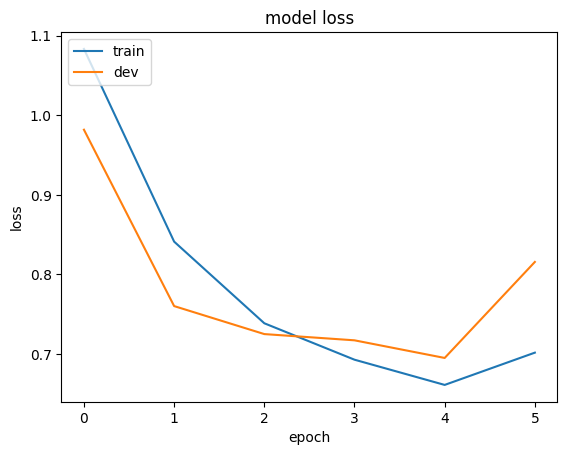

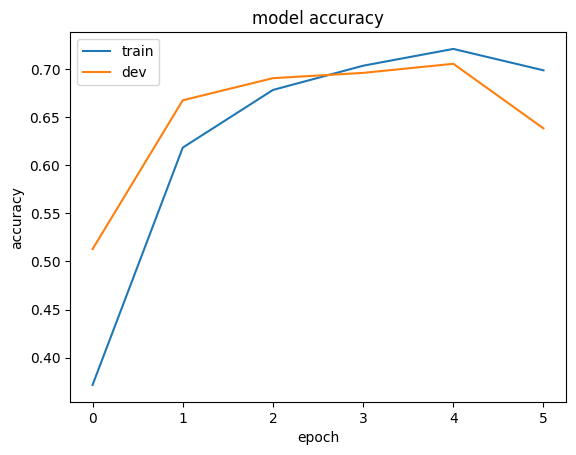

Loss:  0.8170005729610058
Accuracy:  0.6439332247557004


In [27]:
plot_history(history)

test_loss, test_acc = evaluate(model, test_loader)
print('Loss: ', test_loss)
print('Accuracy: ', test_acc)

You can save the model as before.

In [28]:
# serialize model to JSON

model_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/models/'
model_json = model.to_json()
with open(model_home + 'snli-model-with_attention.json', 'w') as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(model_home + 'snli-model-with_attention.weights.h5')

!ls drive/My\ Drive/Colab\ Notebooks/dl4nlp_summer_labs/models


snli-model-no_attention.json	    snli-model-with_attention.json
snli-model-no_attention.weights.h5  snli-model-with_attention.weights.h5


## 4. Attention visualization

The attention model produces output vectors (the attention weights) summarizing contextual information of the premise that is useful to attend over later when reading the hypothesis.

Ploting attention weight can be useful in that it shows to what extent the attentive model focuses on contextual representations of the premise after both GRUs processed the premise and hypothesis respectively. This kind of qualitative analysis helps understanding the model.

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

# Create inverse word index for token lookup
inv_word_index = ['PAD']
for word in sorted(word_index, key=word_index.get):
    inv_word_index.append(word)

@torch.no_grad()
def get_attn(examples):
    model.eval()

    # Handle tensors
    premise_tensor = torch.tensor(examples[0], dtype=torch.long).to(device)
    hypothesis_tensor = torch.tensor(examples[1], dtype=torch.long).to(device)

    # Forward pass to get attention weights
    embedded_premise = model.embedding(premise_tensor)
    embedded_hypothesis = model.embedding(hypothesis_tensor)

    # Process premise through GRU
    premise_outputs, premise_hidden = model.premise_gru(embedded_premise)

    # Process hypothesis through GRU
    hypothesis_output, _ = model.hypothesis_gru(embedded_hypothesis, premise_hidden)
    hypothesis_final = hypothesis_output[:, -1, :]

    # Calculate attention weights (same as in forward pass)
    h_premise = model.W_y(premise_outputs)
    h_hypothesis_part = model.W_h(hypothesis_final)
    h_hypothesis = h_hypothesis_part.unsqueeze(1).repeat(1, model.max_seq, 1)

    added = h_premise + h_hypothesis
    M = torch.tanh(added)

    # Get attention scores and apply softmax
    alpha_scores = model.alpha_projection(M).squeeze(-1)
    alpha = torch.softmax(alpha_scores, dim=1)

    # Convert to numpy and reshape
    attn_weights = alpha.cpu().numpy()
    return np.reshape(attn_weights, [len(examples[0]), max_seq, 1])

def plot_attn(examples):
    attn_weights = get_attn(examples)

    for i in range(len(examples[0])):
        fig = plt.figure(figsize=(30, 10))
        ax = fig.add_subplot(111)
        ax.matshow(np.transpose(attn_weights[i,:,:]), vmin=0., vmax=1., cmap=plt.cm.Blues)
        premise_tokens = [inv_word_index[index] for index in examples[0][i]]
        hypothesis_tokens = [inv_word_index[index] for index in examples[1][i]  if inv_word_index[index] != 'PAD']

        plt.text(2, 1.5, 'H: ' + ' '.join(hypothesis_tokens), fontdict={'size':22})
        ax.set_xticklabels(premise_tokens, rotation=90)
        plt.xticks(np.arange(0, 40, 1.0), fontsize=16)
        plt.yticks(np.arange(0,1,1.0), fontsize=16)

### Exercise 3
The code below prints some visualizations for the given examples. Explore these examples and more, and see if you can identify any patterns in what the model has learned.

There is no clear pattern, but it looks like the following.
- Similar/same words get some attention (e.g. horse, skateboard, football).
- Category is neutral, it looks like the model does not know where to focus.


/tmp/ipython-input-26956772.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  premise_tensor = torch.tensor(examples[0], dtype=torch.long).to(device)
/tmp/ipython-input-26956772.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hypothesis_tensor = torch.tensor(examples[1], dtype=torch.long).to(device)
/tmp/ipython-input-26956772.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(premise_tokens, rotation=90)
/tmp/ipython-input-26956772.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xt

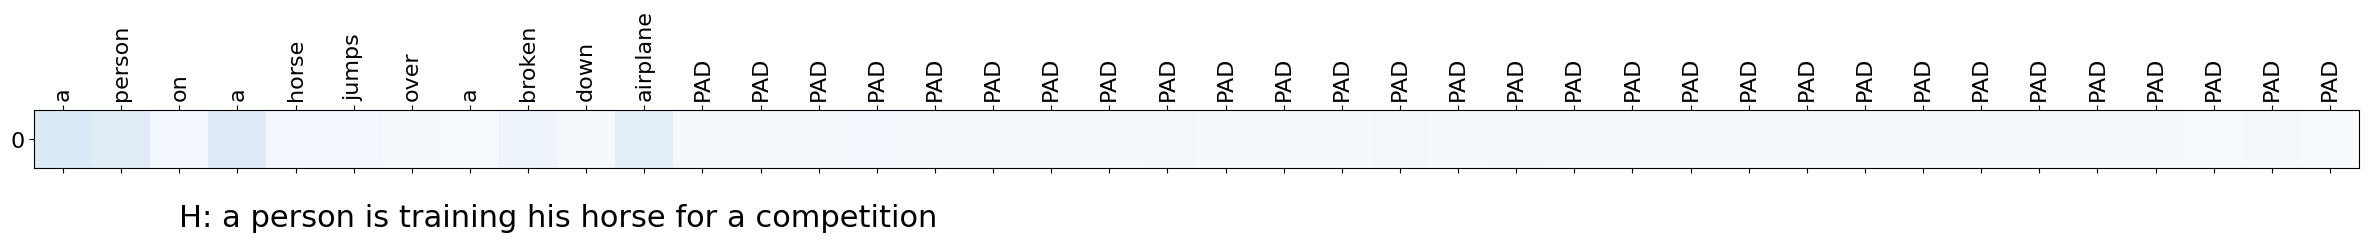

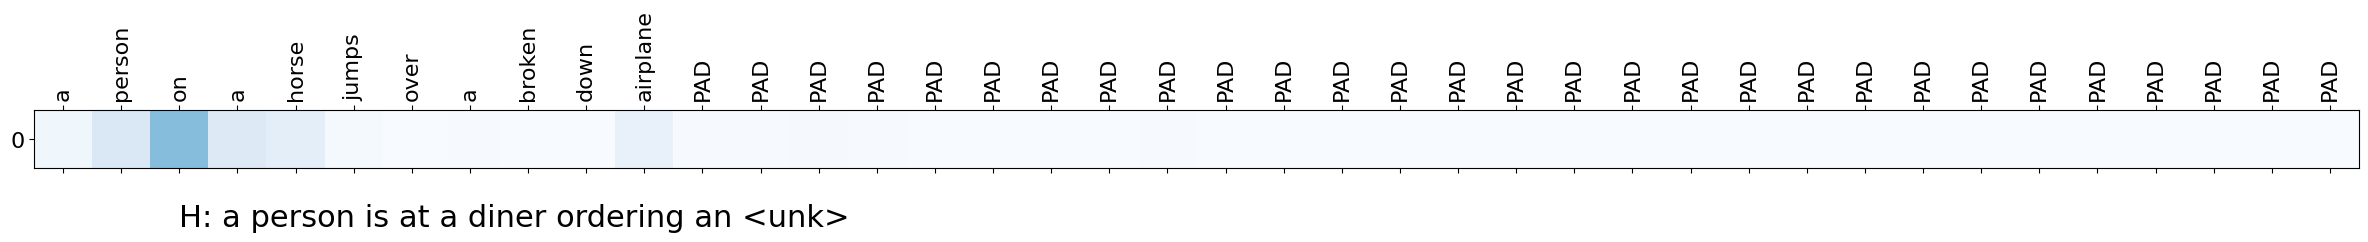

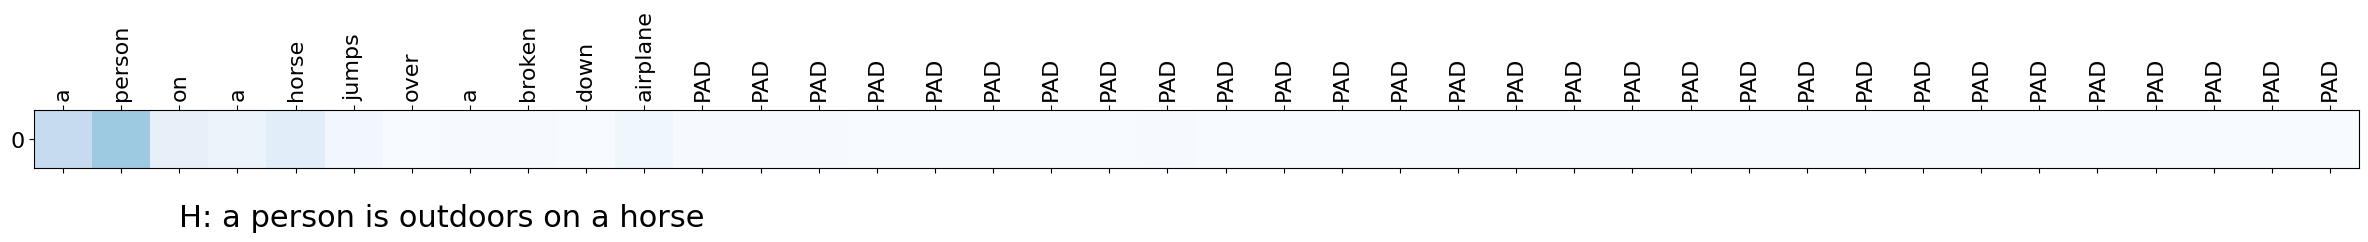

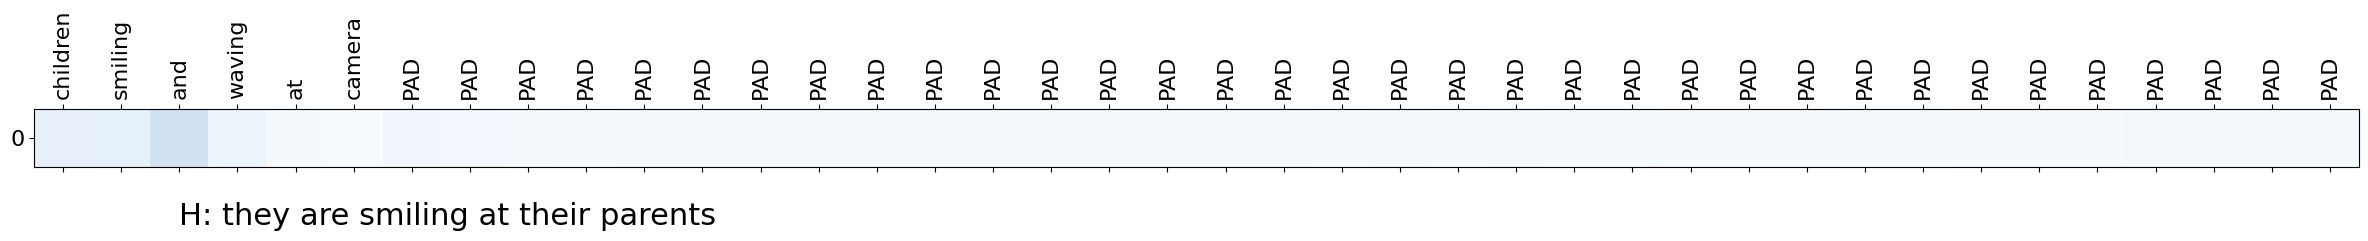

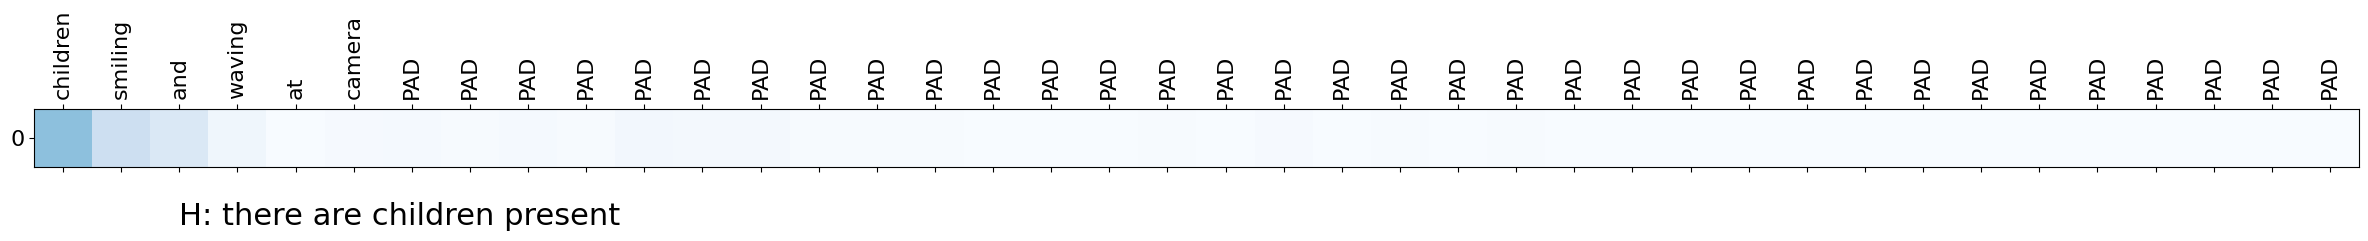

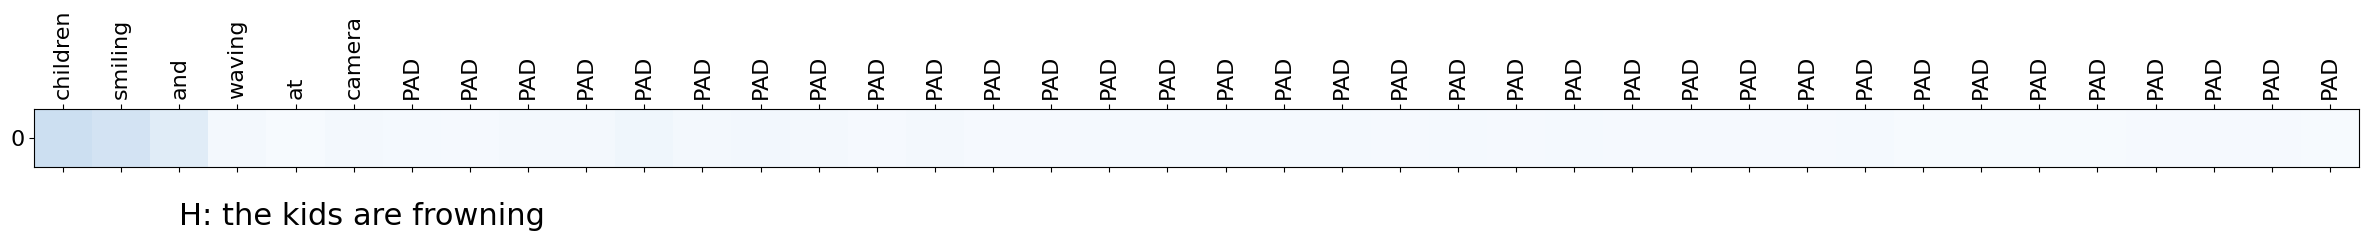

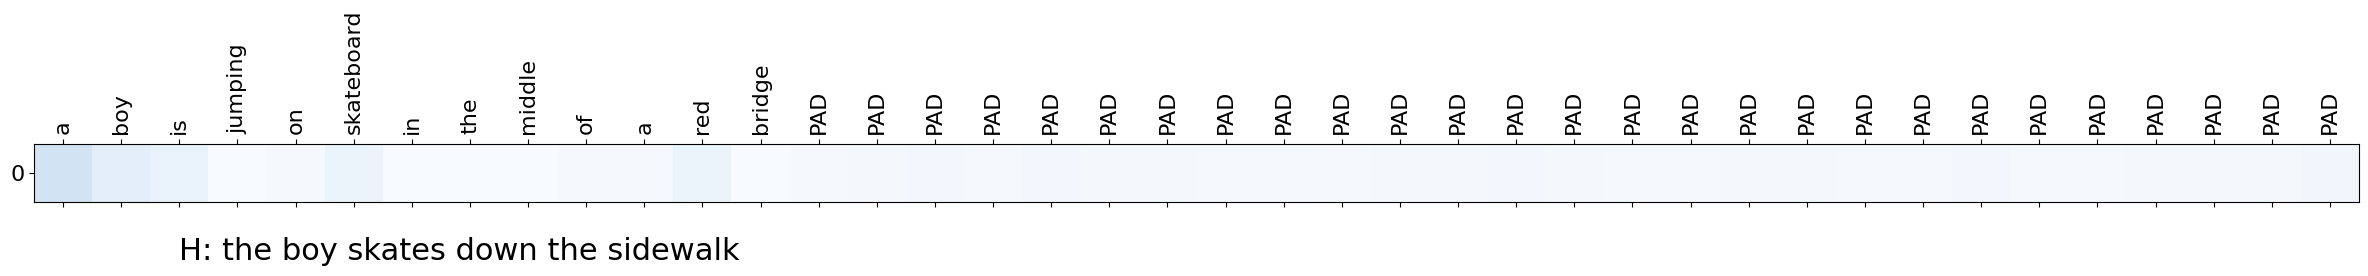

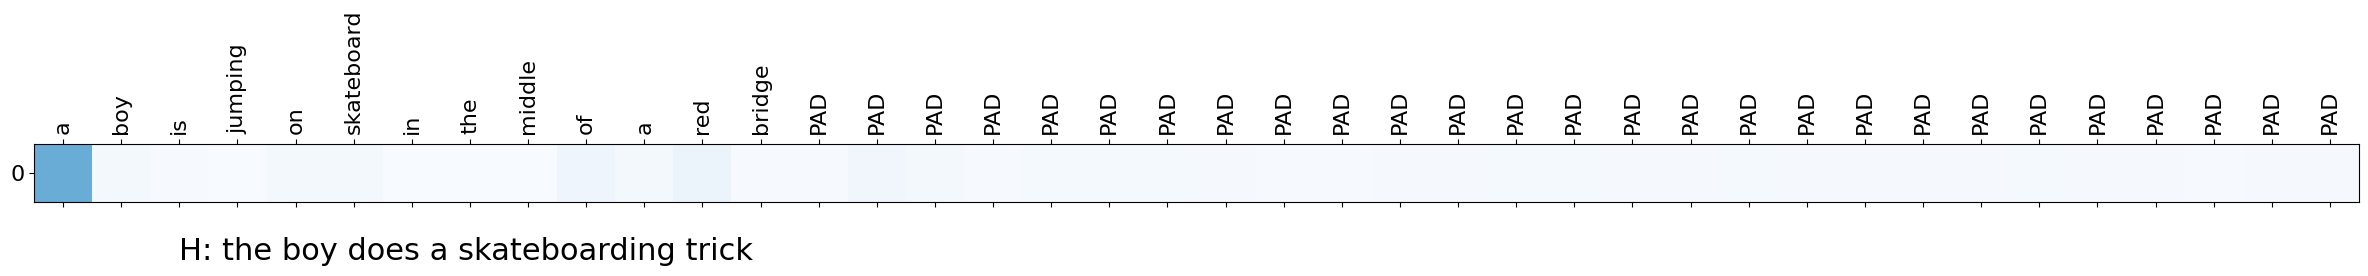

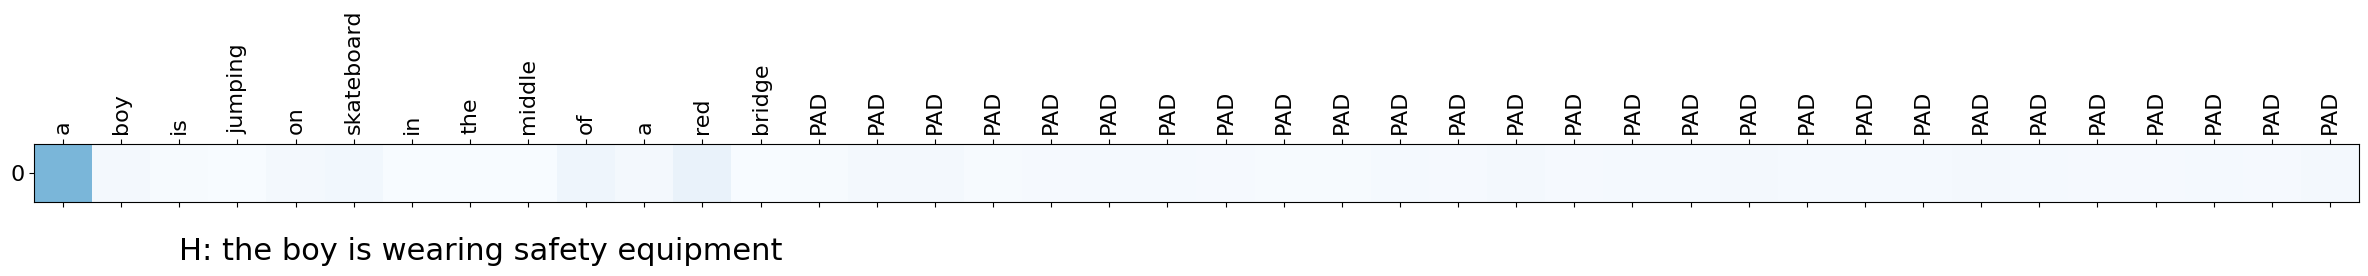

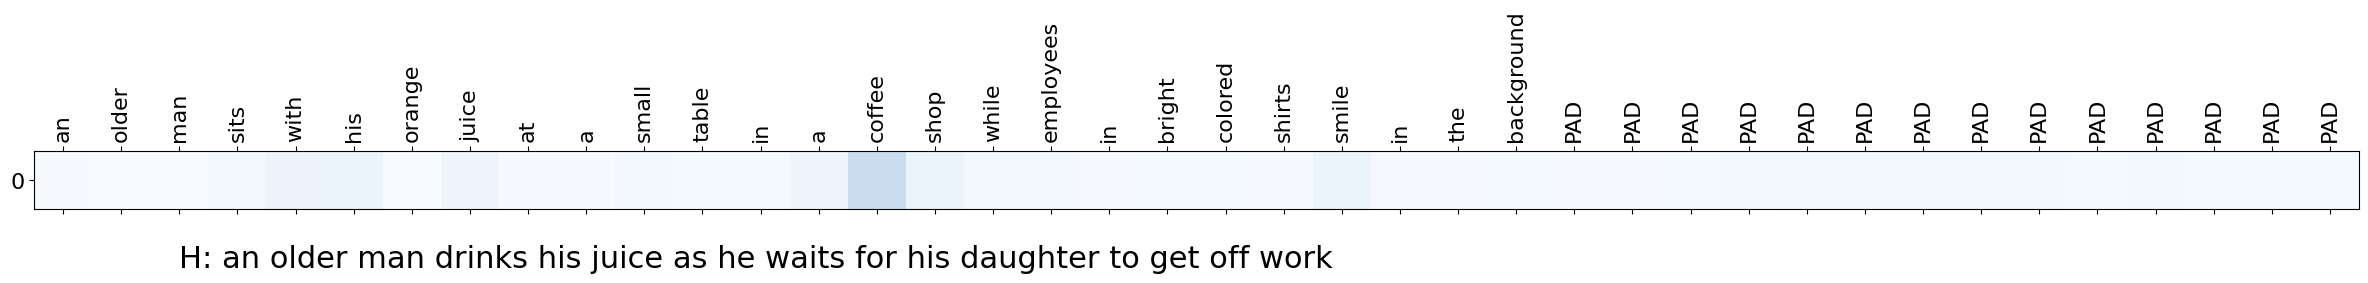

In [30]:
# Plot some attentions of the training examples.
examples = [x_train_premises[:10], x_train_hypotheses[:10]]
attn = plot_attn(examples)

/tmp/ipython-input-26956772.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  premise_tensor = torch.tensor(examples[0], dtype=torch.long).to(device)
/tmp/ipython-input-26956772.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hypothesis_tensor = torch.tensor(examples[1], dtype=torch.long).to(device)
/tmp/ipython-input-26956772.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(premise_tokens, rotation=90)
/tmp/ipython-input-26956772.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xt

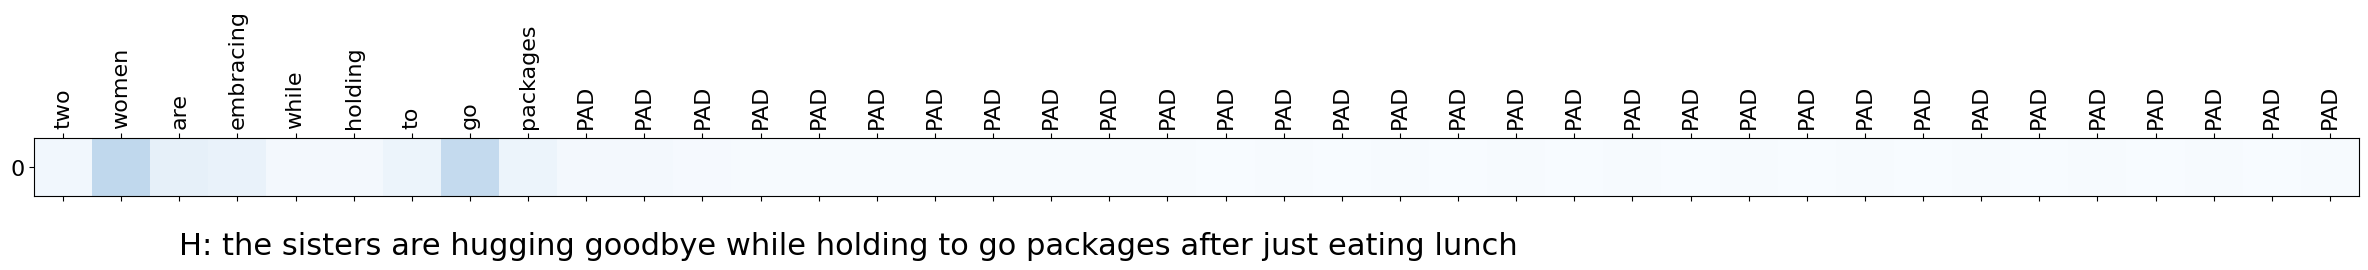

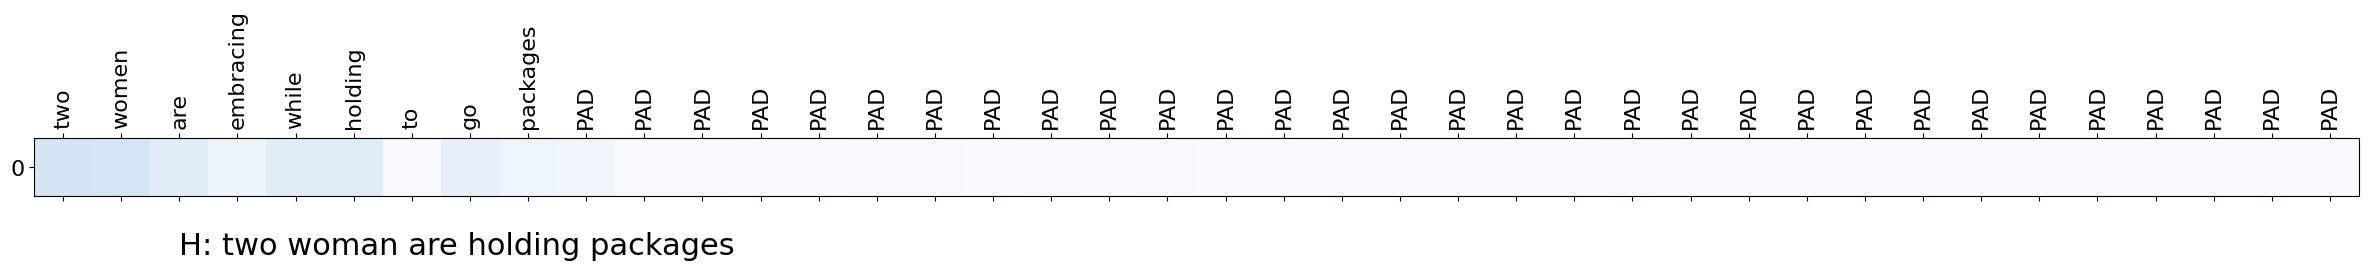

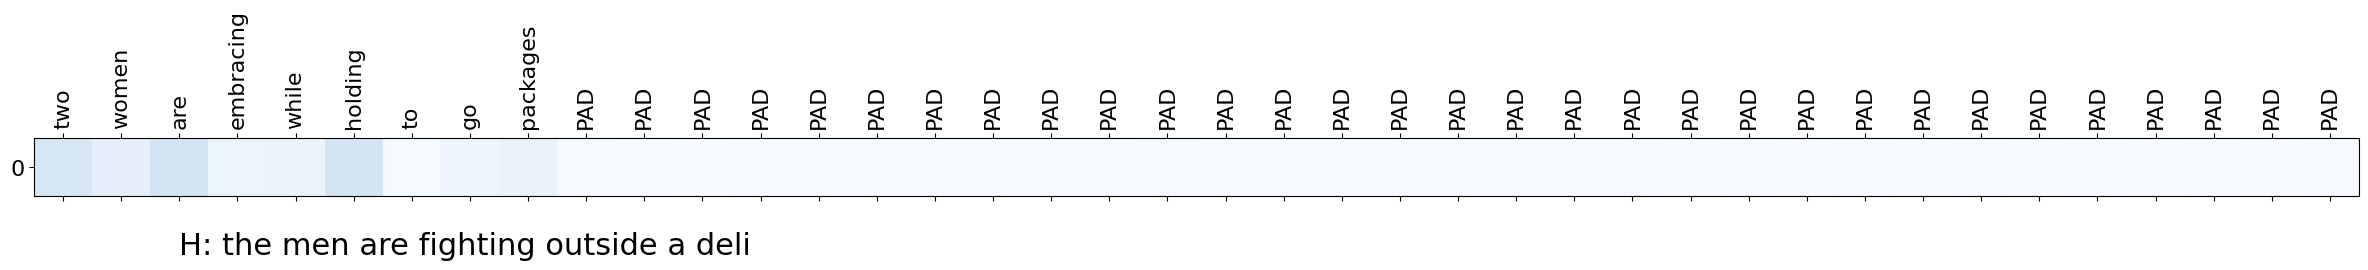

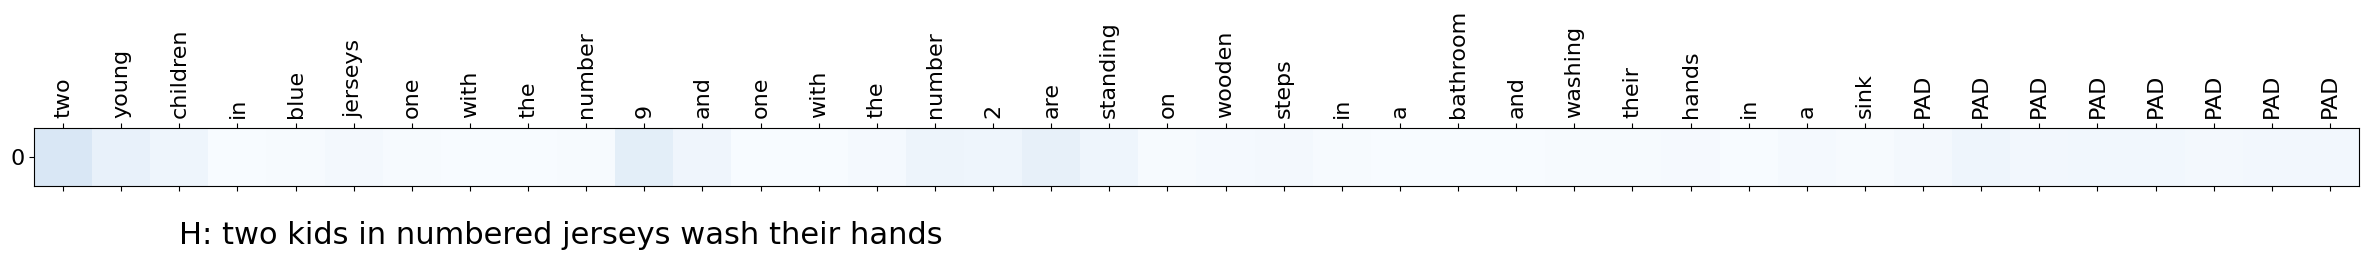

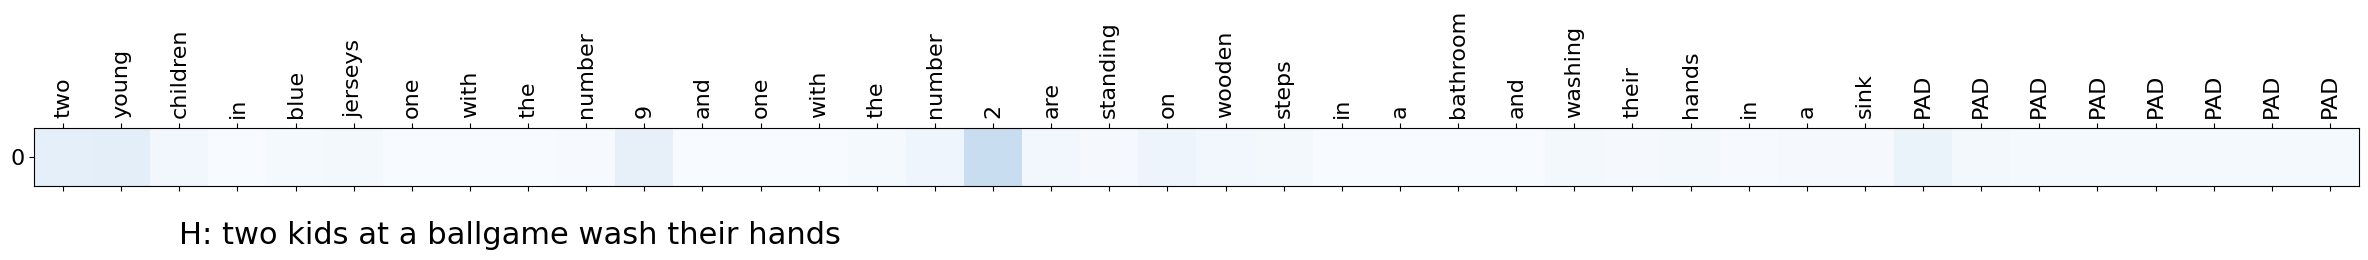

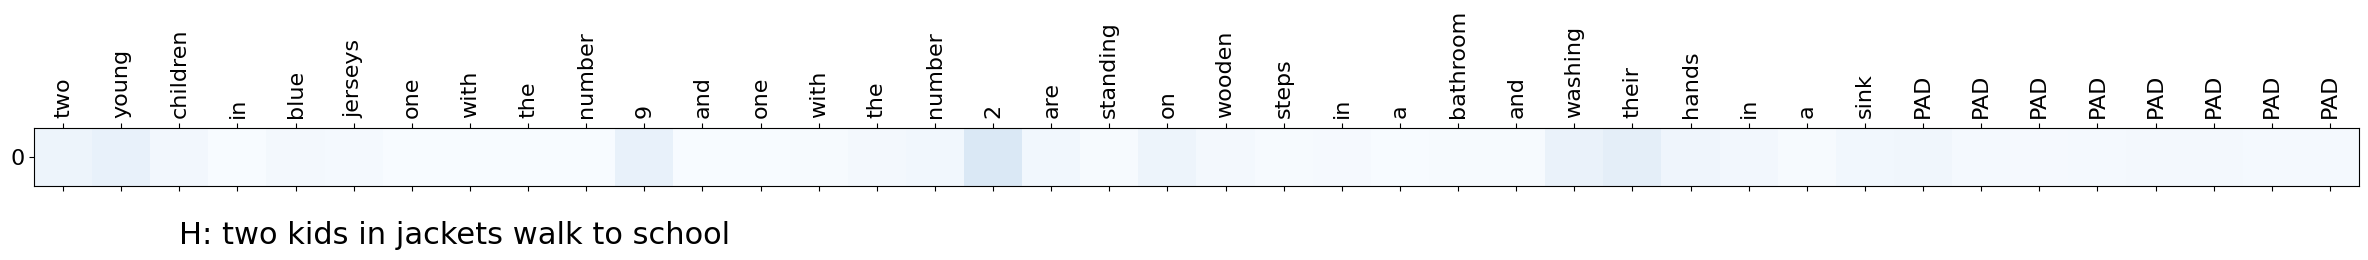

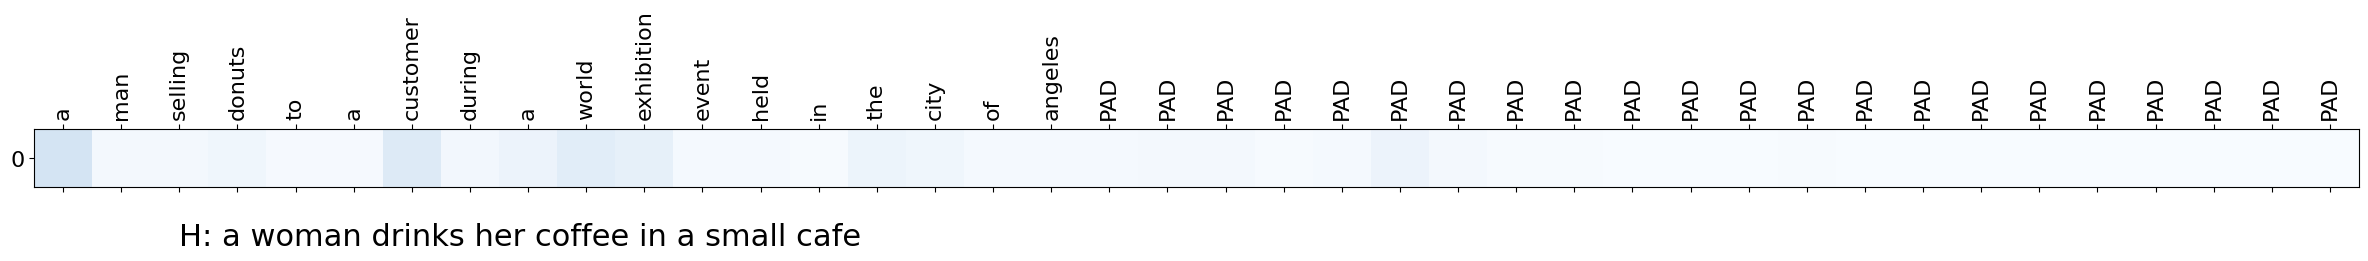

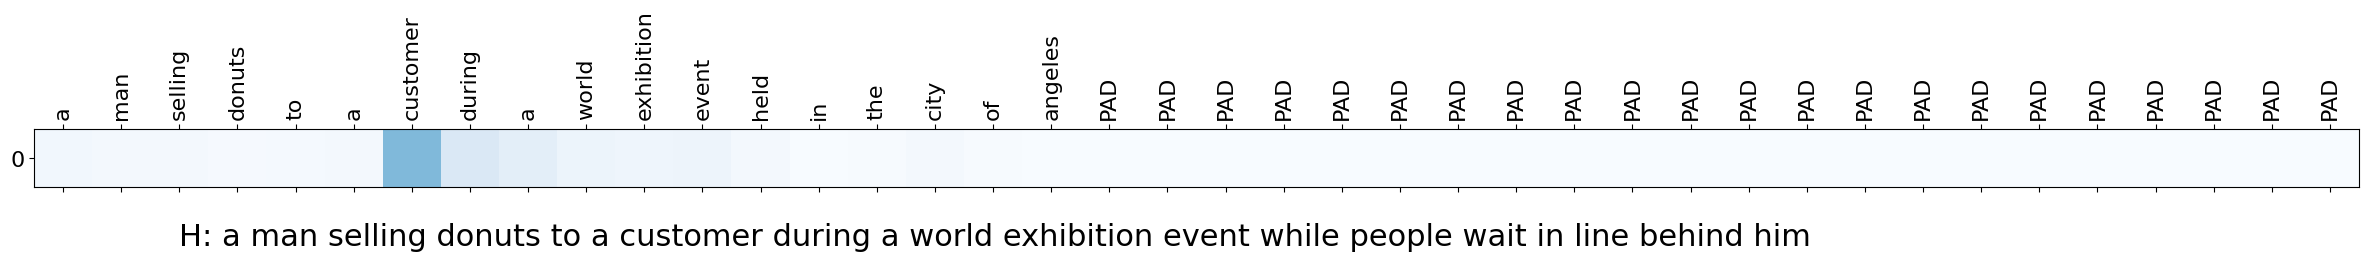

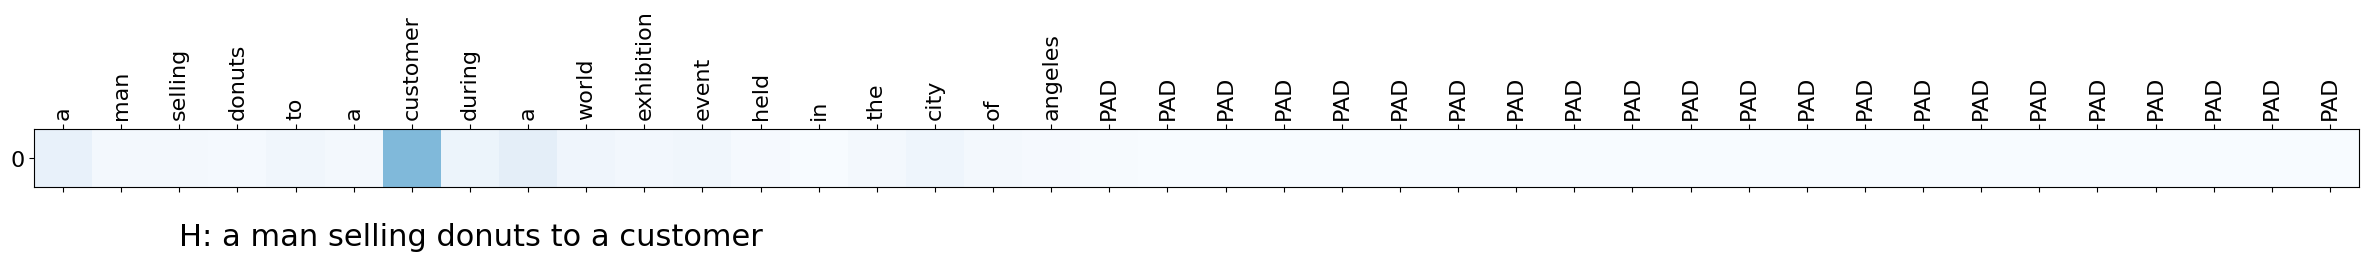

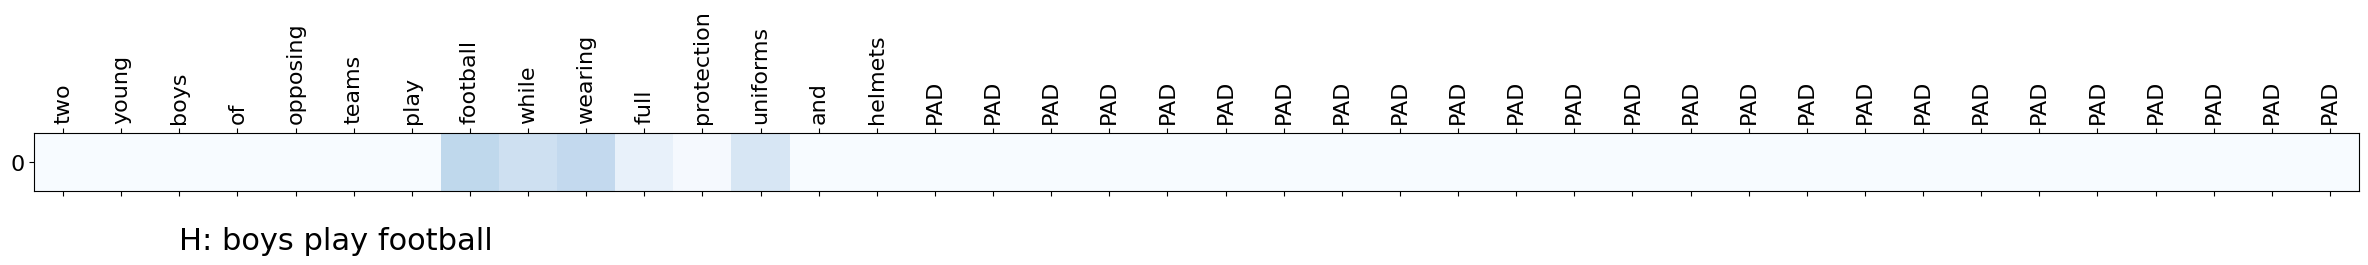

In [31]:
examples = [x_dev_premises[:10], x_dev_hypotheses[:10]]
attn = plot_attn(examples)


---

You can check how much GPU/CPU you are using in your colab sessions.

In [32]:
# memory footprint support libraries/code
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn't guaranteed
gpu = GPUs[0]

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print('GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=4b0fd2f1bd7f9989104b3570d8f37a5085bad846e85112034674a712fd0b81de
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built gputil
Gen RAM Free: 10.2 GB  I Proc size: 2.2 GB
GPU RAM Free: 13070MB | Used: 2024MB | Util  13% | Total 15360MB
